In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os 
from PIL import Image
import matplotlib.pyplot as plt 
import os 
import random 

#model building 
import torch 
import torchvision 
from torchvision.transforms import v2
import torchvision.transforms as T   #for data augmentation
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet34_Weights
from torchvision.models import DenseNet121_Weights
from keras.applications import DenseNet121

#plotting and evaluation
import seaborn as sns 
from sklearn.metrics import confusion_matrix 

#Data Pipeline
from imblearn.over_sampling import RandomOverSampler as ROS #training data oversampling
from sklearn.model_selection import train_test_split #splitting dataframers
from torch.utils.data import Dataset, DataLoader #data pipeline

#utils
import torch.nn.functional as F #softmax
from tqdm import tqdm 


#setting device if a gpu is available 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

2024-08-28 15:57:06.390545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 15:57:06.390870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 15:57:06.575979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(os.listdir("/kaggle/input/"))

['densenet121-weights', 'skin-cancer-mnist-ham10000', 'densenet121pthfile']


In [3]:
# #reading the data 
# base_skin_dir = "/kaggle/input/skin-cancer-mnist-ham10000"
# skin_df = pd.read_csv(os.path.join(base_skin_dir,"HAM10000_metadata.csv"))

# #getting img paths 
# img_path = {}
# for x in glob(os.path.join(base_skin_dir,'*','*.jpg')):
#     img_path[os.path.splitext(os.path.basename(x))[0]] = x

# #adding img_paths and imgs to the df
# skin_df["path"] = skin_df["image_id"].map(img_path.get)
# skin_df["img"] = skin_df["path"].map(lambda x: np.asarray(Image.open(x).resize((32,32))))



In [4]:
# #plotting sample data
# plt.imshow(skin_df["img"][0])
# plt.title(skin_df["dx"][0])

In [5]:
# #applying transforms 
# TRANSFORM_IMG = transforms.Compose([
#     v2.Resize(32), #resizing the image to 32
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.ToDtype(torch.float32, scale = True), #converting input mage to pytorch tensor
#     transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
# ])

# train_data = torchvision.datasets.ImageFolder(root=base_skin_dir, transform = TRANSFORM_IMG)


**Visualing and Balancing Data distribution**

In [6]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [7]:
classes = {0: ('akiec', 'Actinic keratoses'),  
           1:('bcc' , ' basal cell carcinoma'), 
           2:('bkl', 'benign keratosis-like lesions'), 
           3: ('df', 'dermatofibroma'),
           4: ('nv', ' melanocytic nevi'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           6: ('mel', 'melanoma'),
           }
CLASSES  =  [classes[idx][0] for idx in range(len(classes))]
CLASSES_FULL = [[classes[idx][1]] for idx in range(len(classes))]

CLASSES, CLASSES_FULL

(['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'],
 [['Actinic keratoses'],
  [' basal cell carcinoma'],
  ['benign keratosis-like lesions'],
  ['dermatofibroma'],
  [' melanocytic nevi'],
  [' pyogenic granulomas and hemorrhage'],
  ['melanoma']])

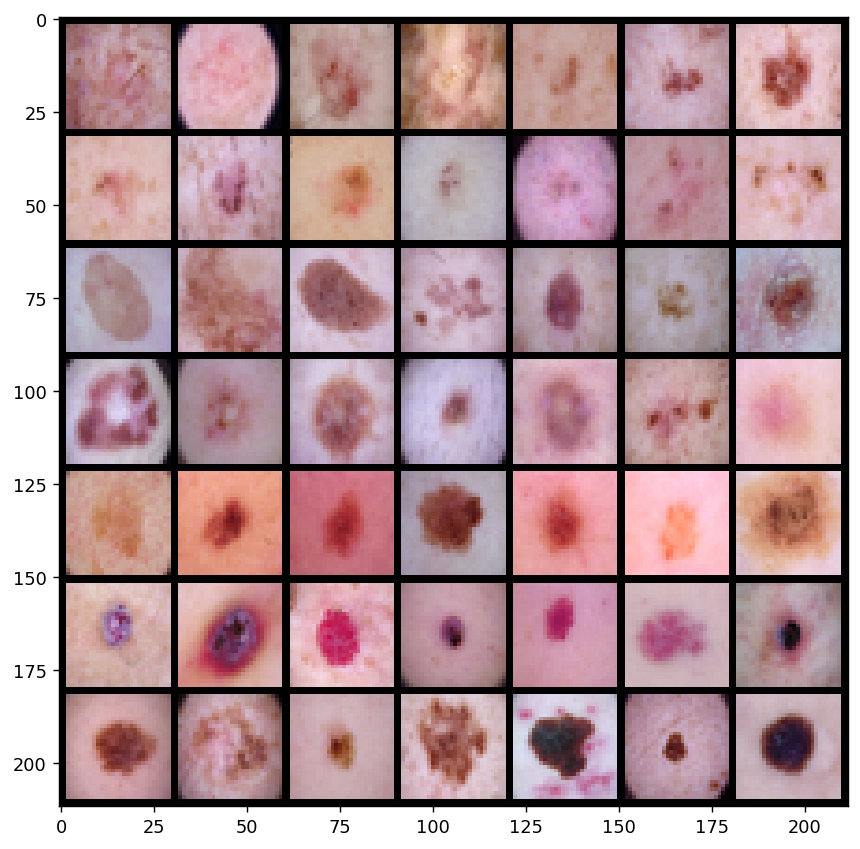

In [8]:
#providing some sample images
n_classes = len(CLASSES)
sample_imgs = []

for cl in classes.keys():
    img_idxs = data["label"] == cl
    n_imgs = len(data[img_idxs])
    chosen = random.sample(list(np.arange(n_imgs)), k= n_classes) 
    
    images = np.asarray(data[img_idxs].iloc[chosen,:-1])# extracting slected images without label in last column
    
    for img in images:
        sample_imgs.append(torch.tensor(img.reshape(28,28,3)).permute(2,0,1))
        
s= torch.stack(sample_imgs)

grid = torchvision.utils.make_grid(s, nrow=n_classes) 


plt.figure(figsize=(8,8), dpi=(128)) # plot the grid
plt.imshow(grid.permute(1,2,0))

    

# Creating a Custom Dataset

In [9]:
class HAM10KDS(Dataset):
    def __init__(self,df,transforms = None, selective = True, OR = 4, normalized = True):
        self.data = df
        self.y = self.data.label
        self.x = self.data.drop(labels = 'label', axis = 1) # dropping labels from columns
        
        #Reshaping the image array into N x height x width x RGB channgel where N = number of samples 
        self.x = np.asarray(self.x).reshape(-1,28,28,3)
        
        #calculating RGb stats for normalization then converting to tensor
        self.mean = torch.tensor([np.mean(self.x[:,:,:,channel]) for channel in range(3)], dtype = torch.float32).reshape(1,3,1,1)
        self.std = torch.tensor([np.std(self.x[:,:,:,channel]) for channel in range(3)],dtype = torch.float32).reshape(1,3,1,1)
        
        
        #converting the images into torch tensors for transforms and training on GPU
        self.x = torch.tensor(self.x,dtype = torch.float32).permute(0,3,1,2)
        
        if normalized == True:
            self.x-= self.mean
            self.x /= self.std
            
        self.resize =T.Resize(size = (28*4,28*4), antialias = True) #Increasing the images by 4 in both dimensinos
        
        
#         self.OR = OR # the label of the over represented class
#         self.selective #the input list of transforms
        self.tf = transforms #input list of transforms    
              
    def __getitem__(self,idx):
        label = torch.tensor(self.y.iloc[idx]) #geting the lable and converting to a tensor
        
        img = self.x[idx] #getting the img from the tensor
        img = self.resize(img) #upscaling the img
        
        
        #Applying the transforms
        if self.tf != None:
            img = self.tf(img)
        
        
        return img, label
    
    def __len__(self):
        return len(self.data)
    

# ****Creating Tests and Train Split****

In [10]:

x = data.drop(labels = 'label', axis = 1) #dropping the label from the dataset
y = data.label #label for the column 

#splitting into train and testing data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

x_train.insert(0,'label', value = y_train.values)
train_df = x_train

x_test.insert(0,'label', value = y_test.values)
test_df = x_test



# **Creating the CNN Model**

In [11]:
#use Densenet121
class CNN(nn.Module):
    def __init__(self, model_name):
        super(CNN,self).__init__()
        
        self.chose_model = model_name
        self.num_classes = 7
        
        
        if self.chose_model == 'resnet34':
            self.model = models.resnet34(pretrained= True) ###there is an error with this line
            
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1),#adds dropout for regularization to prevent overfitting

                nn.Linear(self.model.fc.in_features, 256, bias =False), #applys a linear transformation to the data tor bring it from a higher to to a lower dimention 
                nn.ReLU(),
                nn.BatchNorm1d(256), #256 indicates the input size

                nn.Linear(256,128,bias = False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, self.num_classes, bias = False),
                nn.BatchNorm1d(self.num_classes)
           ) 
            self.model.fc = self.classifier #fully connected layer 
            
            
        elif self.chose_model == 'densenet121':
            
            densenet_path = "/kaggle/input/densenet121pthfile/densenet121-a639ec97.pth"
            state_dict = torch.load(densenet_path)
            self.model =  models.densenet121().load_state_dict(state_dict, strict = False)
            self.model = models.densenet121()
    
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1),#adds dropout for regularization to prevent overfitting

                nn.Linear(self.model.classifier.in_features, 256, bias =False), #applys a linear transformation to the data tor bring it from a higher to to a lower dimention 
                nn.ReLU(),
                nn.BatchNorm1d(256), #256 indicates the input size

                nn.Linear(256,128,bias = False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, self.num_classes, bias = False),
                nn.BatchNorm1d(self.num_classes)
            )
            self.model.classifier = self.classifier
            
            model_parameters = filter(lambda p : p.requires_grad == True, self.model.parameters())
            params = sum([np.prod(p.size()) for p in model_parameters])
            
        
        
    def forward(self,x):
        return self.model(x)
            

# Hyperparametrs

In [12]:
lr = 0.001
bs  = 256
EPOCHS = 40


# Training & Validation Loop 

In [13]:
#Image augmentatino used only for training

#compose composes several transfomrs together
tf = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p = 0.5),
    T.RandomAffine(degrees = 15,
                  translate = (0.1,0.1),
                    scale = (0.9,1.0),
                   shear =(10))
])

#creating a datset and dataloder for train and test 
train_ds = HAM10KDS(train_df, tf)
train_dl = DataLoader(train_ds, batch_size = bs,shuffle = True, pin_memory = True, num_workers = 2)

test_ds = HAM10KDS(test_df, tf)
test_dl = DataLoader(test_ds,batch_size = bs, shuffle = False, pin_memory = True, num_workers = 2)

print("There are", len(train_ds),"training examples and", len(test_ds),"testing examples")


#Creating a cnn model
model = CNN(model_name ='densenet121').to(DEVICE)


#freezing the model and only training the fully connected layers of the model that were added

for p in model.parameters():
    p.requires_grad = False  #prevents backbone layers from being updated during backprop
for p in model.classifier.parameters():
    p.requires_grad = True  #loops through the parameters of classifier and ensure layers are updated during training
    

optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay = 0.1)


#Loss function,have one for train and another for test/eval in case the train loss is different
criterion = nn.CrossEntropyLoss()
eval_criterion = nn.CrossEntropyLoss()

#Learning rate Scheduler - adjusts the learning rate during training to improve convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.1, patience = 3, threshold = 0.0001, threshold_mode = 'rel', cooldown = 0 , min_lr = 0 , eps = 1e-08, verbose = True)
                                        

There are 8012 training examples and 2003 testing examples


In [14]:
highest_acc = .8
EPOCHS = 40 #total number of epochs
FTR_EPOCHS = 5  #first epochs to fine tune the classifer head only, after this then fine tuning happens
LR_MIN = 1e-6 #minimum learning rate, below that training stopping occurs
SAVE_CHECKPOINT = True #flag
SAVE_HIGHEST = True # flag


train_acc = []
train_losses = []
          
test_acc = []
test_losses = []

lrs = []

lr0 = lr*0.01

#lr step for slow warm up from lr0 to lr
lr_step = (lr-lr0)/ (len(train_dl)-1)


best_acc = 0.9 * highest_acc

print(f'Highest accuracy to beat is {highest_acc}')


for epoch in range(EPOCHS):
    loader = tqdm(train_dl)# shows the loading bar 
    losses = [] #logs avg loss per epoch
    accs = [] #logs avg accuracy for each epoch
    correct = 0 #counts how many correct predictions
    count = 0 
    
    if epoch>0:
        #len(train_dl) --> gives the number of batches in the training data loader
        #creates a list with current learning rate repeated len(train_dl) times
        
        lrs+= [optimizer.param_groups[0]['lr']] * len(train_dl)#track lr after warm up  
        
    model.train() #tells you that you are training the model, sets mode to train
    for batch_index,(images, labels) in enumerate(loader):

        #learning rate warmup
        if epoch ==0:
            lr_ = lr0 +lr_step*batch_index #slowly incc reasing lr from lr0 t lr1 in the 1st eppoch

            for op in optimizer.param_groups:
                op['lr'] = lr_

            lrs.append(optimizer.param_groups[0]['lr']) #tracks lr

        #moving data to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        #forward pass
        score = model(images)

        #computing loss
        loss = criterion(score, labels)

        #Backprop & Optimization
        optimizer.zero_grad() #clears the gradient from previous batch
        loss.backward() #backpropogation
        optimizer.step() #gradient descent- upades model parameters

        with torch.no_grad():# ensures that no grads are calculated here / disables ghradient calculation here
            pred = torch.argmax(score, - 1).detach()
            correct += (pred ==labels).sum() # count how many correct
            count += len(labels) 
            acc = correct/count #accumalated accuracy

            losses.append(loss.item()) #records and appends the loss to losses
            accs.append(acc) #records and appends the accuracy to accs

            #progress bar .4f is the number of decimal places 
            loader.set_description(f'TRAIN | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')

            #Epoch training summary
            train_acc.append(acc)
            train_losses.append(torch.tensor(losses).mean().item())




            #testing/validation (Evaluation Loop)
    model.eval()
    with torch.no_grad(): #turning off gradient tracking
        loader = tqdm(test_dl)

        losses =[] #logging loss per mini-batch
        accs = []  #logging running accuracy through one epoch

        correct = 0  #counts how many correct predicitions in one epocuh
        count = 0   #counts # of smaples in one epoch

        for batch_index, (images,labels) in enumerate(loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            score = model(images)
            loss = eval_criterion(score,labels)

            pred = torch.argmax(score, - 1).detach()
            correct += (pred ==labels).sum()
            count+= len(labels)

            acc = correct/count
            loader.set_description(f'TEST | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')

            losses.append(loss.item())
            accs.append(acc)

            #final accuracy and losses are logged
            test_acc.append(acc)
            test_losses.append(torch.tensor(losses).mean().item())

            #adjusts learning rate based on test accuracy(if test accuracy does not imporve learnig rate can be reduced
            scheduler.step(torch.tensor(acc))

    #checkpointing - saves the models highest important categories
    if SAVE_CHECKPOINT == True:
        if test_acc[-1]> best_acc:# if the last test accuracy is greater than the best accuracy
            best_acc = test_acc[-1].item()
            checkpoint  = {
                'model' : model,
                'losses':[train_losses, test_losses],
                'accs': [train_acc, test_acc],
                'lrs' : lrs,
                'best_acc' : best_acc,
                'last_epoch_trained' : epoch,
            }
            if best_acc> highest_acc and SAVE_HIGHEST == True:
                old_highest_acc = highest_acc
                highest_acc = best_acc
                torch.save(highest_acc, 'highest_acc.pt')

                # if model achieves highest accuracy so far, saves trhe accuracy and logs achievement
                print(f'HIGHEST ACCURACY SURPASSES FROM {old_highest_acc} to {highest_acc}')
                torch.save(checkpoint, f'{highest_acc:.4f} checkpoint.pt')

            torch.save(checkpoint, 'checkpoint.pt')
            print(f'Checkpointed wi {best_acc:.4f} best acc')

    if optimizer.param_groups[0]['lr'] < LR_MIN:
        print(f'EARLY STOPPING! LR BELOW {LR_MIN}')
        break



Highest accuracy to beat is 0.8


TRAIN | epoch 1/40 | acc 0.3693 | loss 1.6846: 100%|██████████| 32/32 [05:26<00:00, 10.20s/it]
TEST | epoch 1/40 | acc 0.5586 | loss 1.5632:   0%|          | 0/8 [00:09<?, ?it/s]/tmp/ipykernel_18/1281314032.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scheduler.step(torch.tensor(acc))
TEST | epoch 1/40 | acc 0.5336 | loss 1.6453:  62%|██████▎   | 5/8 [00:43<00:25,  8.59s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


TEST | epoch 1/40 | acc 0.5407 | loss 1.6632: 100%|██████████| 8/8 [01:08<00:00,  8.53s/it]
TRAIN | epoch 2/40 | acc 0.5619 | loss 1.4882: 100%|██████████| 32/32 [05:06<00:00,  9.57s/it]
TEST | epoch 2/40 | acc 0.5477 | loss 1.5753:  62%|██████▎   | 5/8 [00:42<00:25,  8.39s/it]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


TEST | epoch 2/40 | acc 0.5482 | loss 1.6117: 100%|██████████| 8/8 [01:05<00:00,  8.20s/it]
TRAIN | epoch 3/40 | acc 0.5632 | loss 1.5756: 100%|██████████| 32/32 [05:03<00:00,  9.49s/it]
TEST | epoch 3/40 | acc 0.5586 | loss 1.4765:  12%|█▎        | 1/8 [00:09<01:09,  9.88s/it]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-06.


TEST | epoch 3/40 | acc 0.5469 | loss 1.5299:  62%|██████▎   | 5/8 [00:42<00:24,  8.24s/it]

Epoch 00021: reducing learning rate of group 0 to 1.0000e-07.


TEST | epoch 3/40 | acc 0.5482 | loss 1.5514: 100%|██████████| 8/8 [01:05<00:00,  8.24s/it]

EARLY STOPPING! LR BELOW 1e-06
